In [26]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import os

In [27]:
df = pd.read_csv('trainMa.csv')

In [28]:
directory = "Medical mask/Medical Mask/annotations"
image_directory = 'Medical mask/Medical Mask/images'

In [29]:
cvNet = cv2.dnn.readNetFromCaffe('architecture.txt',
                                 'weights.caffemodel')

In [30]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
          return json.load(f)

In [31]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [32]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)    

In [33]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

In [34]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [35]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [36]:
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

In [37]:
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

In [38]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

In [39]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/50


/var/folders/qt/11wp7xx1493f_p0_rlcbnb5r0000gn/T/ipykernel_10557/236293644.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
2023-02-21 20:14:47.033173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


143/143 [==============================] - ETA: 0s - loss: 0.4192 - accuracy: 0.8281

2023-02-21 20:15:49.930323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


143/143 [==============================] - 71s 490ms/step - loss: 0.4192 - accuracy: 0.8281 - val_loss: 0.2947 - val_accuracy: 0.8922
Epoch 2/50
143/143 [==============================] - 70s 486ms/step - loss: 0.2933 - accuracy: 0.8704 - val_loss: 0.2185 - val_accuracy: 0.9130
Epoch 3/50
143/143 [==============================] - 68s 478ms/step - loss: 0.2882 - accuracy: 0.8833 - val_loss: 0.2190 - val_accuracy: 0.9235
Epoch 4/50
143/143 [==============================] - 69s 485ms/step - loss: 0.2703 - accuracy: 0.8883 - val_loss: 0.2164 - val_accuracy: 0.9139
Epoch 5/50
143/143 [==============================] - 69s 481ms/step - loss: 0.2550 - accuracy: 0.9015 - val_loss: 0.2057 - val_accuracy: 0.9261
Epoch 6/50
143/143 [==============================] - 68s 477ms/step - loss: 0.2522 - accuracy: 0.9004 - val_loss: 0.2155 - val_accuracy: 0.9235
Epoch 7/50
143/143 [==============================] - 69s 480ms/step - loss: 0.2516 - accuracy: 0.9026 - val_loss: 0.2097 - val_accuracy: 0.9

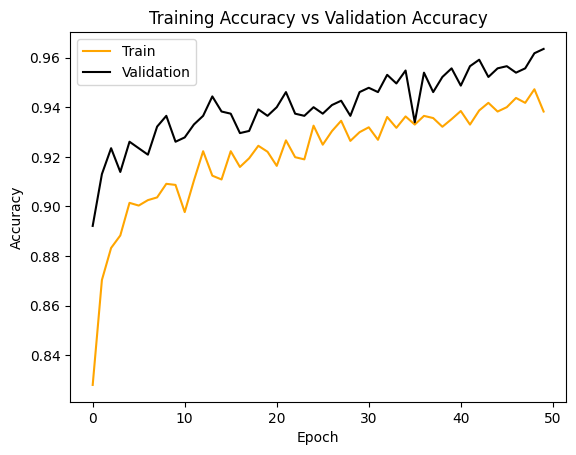

In [40]:
plt.plot(history.history['accuracy'],'orange',label='Train')
plt.plot(history.history['val_accuracy'],'black',label='Validation')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

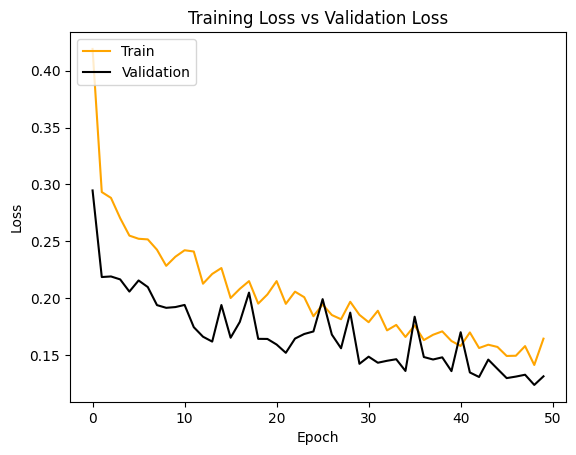

In [41]:
plt.plot(history.history['loss'],'orange', label = 'Train')
plt.plot(history.history['val_loss'],'black', label='Validation')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( loc='upper left')
plt.show()

In [54]:
mainDirctory = os.getcwd()
directory = os.path.normpath(mainDirctory + os.sep + os.pardir)


model.save(directory+"/task3/trainedMODEL2.h5")

1/1 [==============================] - 0s 11ms/step


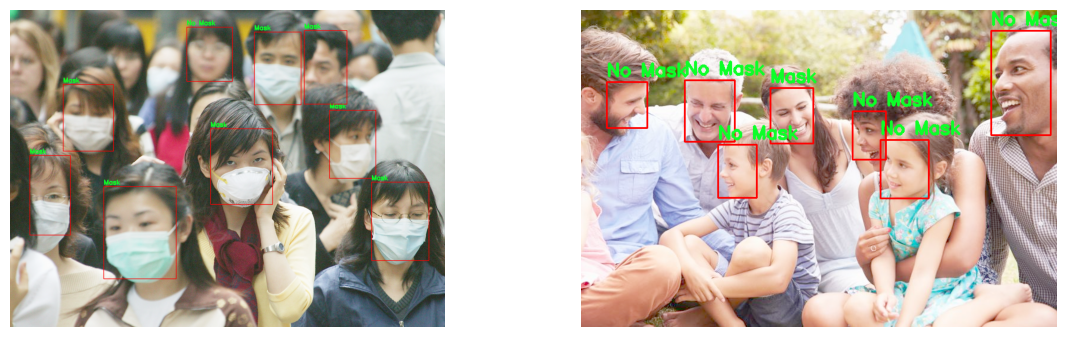

In [57]:

images = [(mainDirctory+'/0233.jpg'),(mainDirctory+'/family.jpg')]
gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (320,320)), 1.0, (320, 320), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (40,255,12), 3)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()